<a href="https://colab.research.google.com/github/Intelligence-Engineering-LAB-KU/Seminar/blob/master/Seminar/fall_2020/1020_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

# 1 Overview

## Review

이전 시간까지 우리는 기계 번역 혹은 sequence transduction의 경우에 주로 사용 되는 seq2seq과 그것에 Attention Mechanism을 첨가한 아키텍처에 대해 공부했다. 우리가 Transformer를 공부하기에 앞서 이들에 대해 주목할 점은, 모두 **인코더와 디코더로 구성**되었다는 것이다.

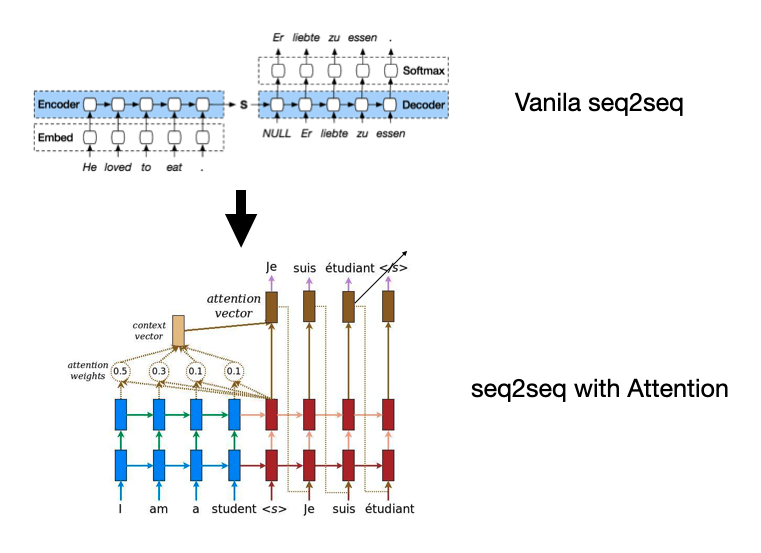

In [34]:
Image('qq2.png')

## Overview

우리가 이번 시간에 공부할 트랜스포머 역시 개략적으로 볼 때 **인코더와 디코더로 구성**되었다고 말해질 수 있다. 하지만 이 트랜스포머에는 앞에서 공부한 것들보다 더 많은 구성 요소들을 가지고 있다. 우리는 트랜스포머를 공부하기 위해 먼저 트랜스포머의 대략적인 구조를 살펴본 뒤에, 그것의 구성 요소들에 대해 자세히 알아볼 것이다. 

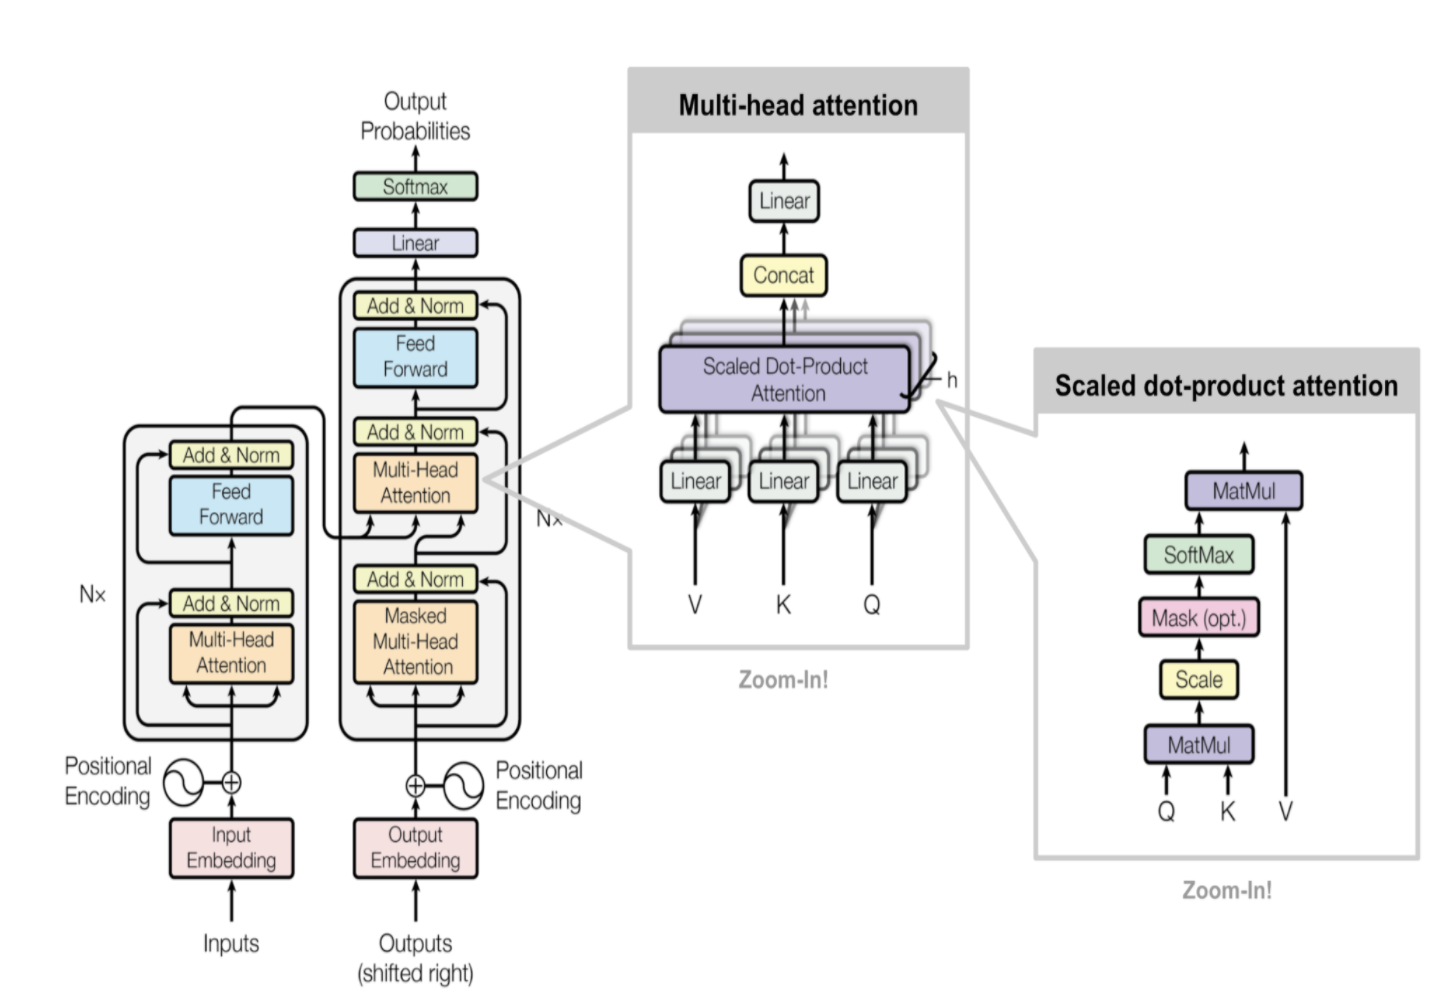

In [ ]:
Image('t1.png')

# 2 Motivation  


기계 번역, 언어 모델 등 같은 작업에서 RNN, GRU 등은 최신 기술로서 성공적인 발전을 이루었다. Recurrent 모델은 보통 이전 은닉 상태 $h_{t-1}$과 해당 포지션 t의 입력을 통해, 현재 은닉 상태 $h_t$ 시퀀스를 만들어낸다.  
- **Motiv 1** 
 > RNN의 위 같은 속성은 training examples 내의 병렬화parallelization를 방해한다. 긴 길이의 시퀀스를 처리하는 경우에, 이 난점은 학습 속도를 크게 저하시킨다.  

- **Motiv 2**  
 > Transformer는 recurrence에 의존하지 않는 아키텍처이다. 이것은 input과 output 간의 대역적 의존 관계global dependencies를 끌어내는 **어텐션 메커니즘**에만 의존한다. 그러한 탓에, RNN 사용 시 얻는 난점을 피할 수 있다. 

# 3 Architecture


### Contents    
- Terms
- Encoder, Decoder  
- Residual Connection
- Positional Encoding  
- Scaled Dot-Product Attention  
- Multi-head Attention  
- Position-wise Feed-Foward Networks  

- Summary

트랜스포머 아키텍처도 크게 볼 때, 인코더 - 디코더 구조를 가진다. 하지만 이전에 살펴보았던, seq2seq, seq2seq with Attention 보다는 다소 복잡한 형태를 지닌다. 우리는 제안된 이 트랜스포머의 구조에 대해 알아보기 위해, 이번 절에서 이것을 구성하는 부분들에 대해 자세히 살펴본다. 그 전에 우리는 먼저 Encoder와 Decoder에 대해 개괄적으로 알아본다.

### Terms

$d_{model}$  = 512  

> 트랜스포머의 인코더와 디코더에서의 **정해진 입력과 출력의 크기**를 의미합니다. 즉, **임베딩 벡터**의 크기 또한 $d_{model}$이며, 각 인코더와 디코더가 **다음 층의 인코더와 디코더로 값**을 보낼 때에도 이 크기를 가집니다. 논문에서 $d_{model}$은 512 입니다..
  

num_layers = 6  

> 트랜스포머에서 하나의 인코더와 디코더를 층으로 생각하였을 때, 트랜스포머 모델에서 인코더와 디코더가 총 몇 층으로 구성되었는지를 의미합니다. 논문에서는 인코더와 디코더를 각각 총 6개 쌓았습니다.

num_heads = 8
> 트랜스포머에서는 어텐션을 사용할 때, 1번 하는 것 보다 여러 개로 분할해서 병렬로 어텐션을 수행하고 결과값을 다시 하나로 합치는 방식을 택했습니다. 이때 이 병렬의 개수를 의미합니다.

$d_{ff}$ = 2048  

> 트랜스포머 내부에는 피드 포워드 신경망이 존재합니다. 이때 은닉층의 크기를 의미합니다. 피드 포워드 신경망의 입력층과 출력층의 크기는 $d_{model}$의 크기를 가집니다.  
  
*https://wikidocs.net/31379 발췌* 

## 3.1 Encoder, Decoder  
  
- **Encoder:** 인코더는 6 개의 동일한 Layer들의 스택으로 구성되어 있다. 여기서 각 Layer는 2 개의 sub-layers로 구성된다.  
 > - sub-layers  
    - Multi-Head (self) Attention  
    - Position-wise fully connected feed-forward network (Feed Forward)  

------------------
  - 위의 두 sub layers는 [Residual Connection](https://arxiv.org/abs/1512.03385) 방식으로 연결된다.
  - 이 sub-layers들 뒤에는 [Layer-normalization](https://arxiv.org/abs/1607.06450)이 뒤따른다. 
------------------  
- **Decoder:** 디코더도 인코더의 구조와 거의 비슷하다. 다만, 여기서의 Multi-Head Attention은 Masking이 적용된다는 점에서 인코더의 그것과 다소 차이가 있다.

In [18]:
def clones(module,N):
    " To copy N identical layers"
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [19]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        
        super(Encoder,self).__init__()
        self.layers = clones(layer,N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):

        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)

References [4]를 참고하여 코드를 수정 및 발췌 

### Embedding

In [20]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.embed = nn.Embedding(vocab, d_model) # vocab refers to vocabulary size, d_model=512 according to the original paper.

    def forward(self, x):
        return self.embed(x)

## 3.2 Residual Connection

인코더와 디코더에서 두 sub layers는 Residual Connection 방식으로 연결된다. 이것은 기존에 사용하던 Plane Layer와 다소 차이가 있다.

### Motivation  
  
- Deeper Net이 Shallower Net 보다 낮은 성능을 보이는 문제가 종종 발생 
 > Residual Connection은 이러한 곤경을 극복하게 해준다.

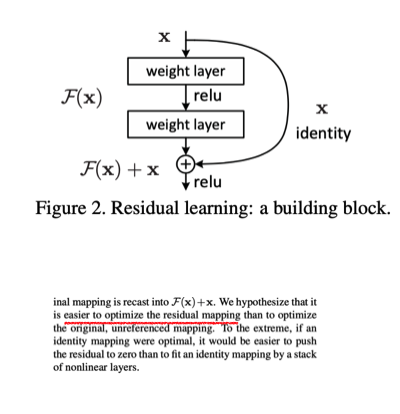

In [3]:
Image('qq3.png')

저자는 위 같은 문제는 Deeper Net 시 최적화(Train)하는 것이 더 어렵기 때문에 발생한다고 추측한다. 그는 실험을 통해 원래의 방법 (e.g. input > layer1 > relu > layer2 > output) 보다 위 같은 Residual Connection 방식으로 레이어들을 구성할 시, Deeper Net이 Shallower Net 보다 더 좋은 성능을 보인다는 것을 증명했다.   
일반적인 NN에서는, 즉 $y=f(x)$인 경우에는, 기존의 정보를 변형시켜 새로운 정보를 생성하는 반면에, 이 Residual 방식에서는, $y=f(x)+x에서는$, input x를 더함으로써 학습된 정보에 **기존의 정보**를 그대로 보존하여 출력 시에 첨가한다. Residual Connection에서는 이 같은 방식으로 Deeper Net의 Optimize를 돕는다.  

우리가 이번에 알아볼 Transfomer에서는 이 방식을 사용하여 Sub-Layers를 연결한다.  
  

참고: [7](https://itrepo.tistory.com/36)

In [21]:
class SublayerConnection(nn.Module):

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout(self.norm(x))

## 3.3 Layer Normalization

- [Layer Normalization](https://arxiv.org/abs/1607.06450)은 배치 정규화의 개선된 버젼이라고 간주될 수 있다.   

- 배치 정규화는 출력값의 분포가 바뀌는 소위 내부 공변량 변화 Internal Covariant Shift 현상을 개선하기 위해 고안되었다. 이것은 매 Layer 마다 FFN과 Activation 사이에 삽입하여, 평균을 0, 분산을 1로 만들어주어, 학습을 더 빠르고 안정적으로 할 수 있게 만들어준다.  

- 하지만 배치 정규화는 (1) 미니 배치의 크기에 의존적이고, (2) RNN 같이 매 timestep 마다 다른 통계값statistics를 요구하는 경우에 적용되기 어렵다는 한계가 있다. 이것을 극복하기 위해 개선된 것이 Layer Normalization이다.  



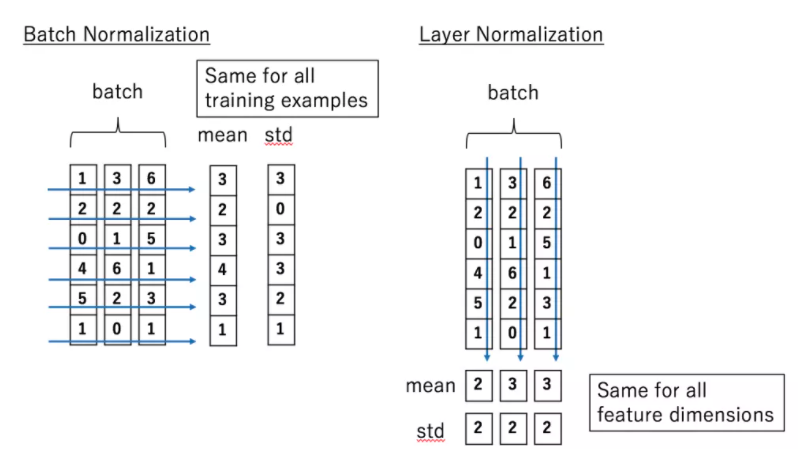

In [4]:
Image('q7.png',width=600)

배치 정규화와 레이어 정규화 간의 수행적인 측면에서의 주된 차이를 설명하기 위해, 위 그림을 참고하는 것은 적절한 것 같다.  



- **배치 정규화:** 이것은 배치(또는 미니-배치)를 묶어 학습을 시킨다. 즉, 모두 동일한 트레이닝 사례training examples에 대한 통곗값을 구한다.   
> $\mu_j = \frac{1}{m}\sum_{i=1}^m x_{ij}$  
$\sigma_j^2 = \frac{1}{m} \sigma_{i=1}^m (x_{ij} - \mu_j)^2$  
$\hat{x_{ij}}=\frac{x_{ij}-\mu_j}{\sqrt{\sigma_i^2 + \epsilon}}$  
$y_{ij} = \gamma \hat{x_{ij}}+\beta$
  
- **레이어 정규화:** 이것은 배치 정규화와 다르게, 모두 동일한 Feature Dimensions를 묶어 학습을 시킨다.  
 > $\mu_i = \frac{1}{m}\sum_{j=1}^m x_{ij}$  
$\sigma_i^2 = \frac{1}{m} \sigma_{j=1}^m (x_{ij} - \mu_j)^2$  
$\hat{x_{ij}}=\frac{x_{ij}-\mu_j}{\sqrt{\sigma_i^2 + \epsilon}}$  
$y_{ij} = \gamma \hat{x_{ij}}+\beta$

배치정규화는 $j$에 대해서, 레이어 정규화는 $i$에 대해서 통곗값을 구한다는 점에 주목하라.

더 자세한 논의: [6](https://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/) 참고

In [23]:
import math
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.gamma = nn.Parameter(torch.ones(features))
        self.beta = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):

        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)

        LN = (x-mean)/math.sqrt((std+self.eps))
        LN = self.gamma*LN + self.beta

        return LN

## 3.4 Positional Encoding

Raw Input은 Embedding Layer를 통과한 뒤, Self-Attention Layers에 들어가기 이전에 Positional Encoding을 거친다. 왜 이것을 거치는 것이고, 이것은 무슨 역할을 하는가?

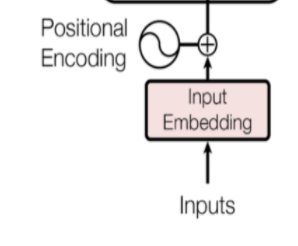

In [8]:
Image('/content/drive/My Drive/img/transformer/q1.png',width=400,height=200)

 >단어의 위치 정보를 얻기 위해 사용하는 Positional Encoding

우리는 RNN 기반의 seq2seq에서는 RNN의 특성을 사용하여 단어를 순차적으로 입력받아 각 단어의 위치 정보를 얻을 수 있었다. 하지만 위에서 말했듯이 Transformer는 RNN에 의존하지 않는데, 그 때문에 **단어의 위치 정보**를 얻을 다른 방식이 요구된다. 이것을 수행하기 위해 Transformer에서 사용되는 기법은 **Positional Encoding**이라 불린다. 

- Positional Encoding은 아래 같이 sin part와 cos part로 나눠져 수행된 뒤에, 하나로 연접concatenate된다.

- $PE_{pos,2i}=sin(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$  where $d_{model} = 512$ in the original paper
  
- $PE_{pos,2i+1}=cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$ 

### Example

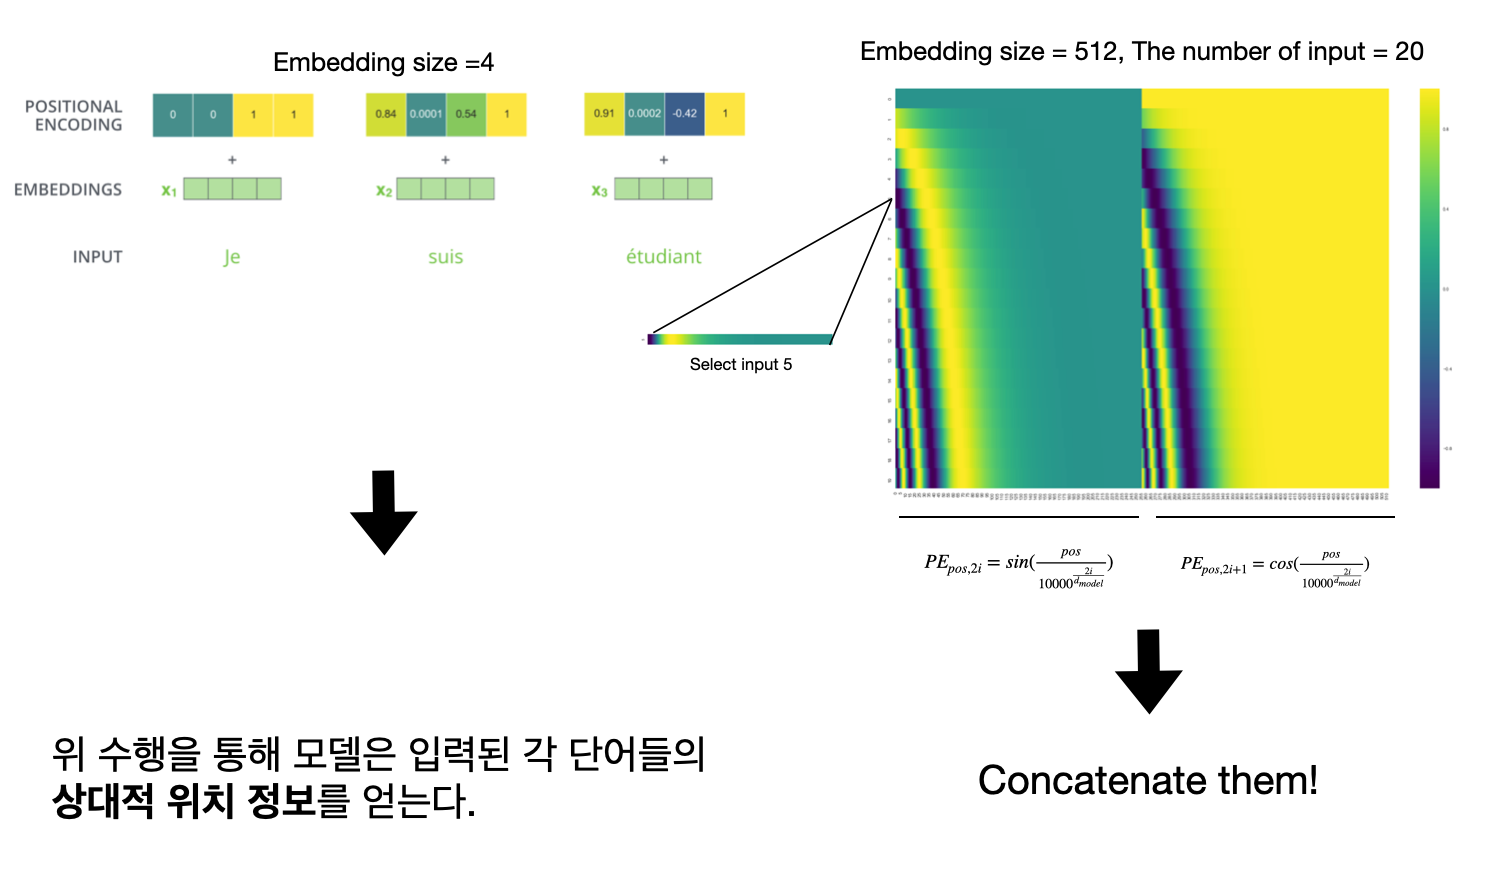

In [12]:
Image('/content/drive/My Drive/img/transformer/q3.png')

- 좌측 그림을 보자.  
> 좌측 그림은 (정현파)위치 인코딩을 간략히 보여준다. 이것은 -1에서 1 사이의 값을 각 input의 벡터에 부여한다. 이 그림의 embedding size는 4이기 때문에 4 개의 값이 할당되었다. 3 개의 inputs의 벡터값은 각자 고유한 값을 갖고, 이 값은 각 input의 **상대적 위치 정보**를 함축한다.  
  


- 우측 그림을 보자.  
 > 우측 그림은 좌측 그림과 같이 위치 인코딩의 결과를 보여준다. 단, 이번에는 input =20, embedding size = 512인 경우이다. 세로축은 Position(for input), 가로축은 Positional Embedding을 가리킨다.  
- 설명  
  - 이 그림의 좌측 절반은 sine 함수로 수행되었고, 우측 절반은 cosine 함수로 수행되었다.  
  - 위 그림에서 블록의 색은 어두울수록 -1에 가깝고, 노랑에 가까울수록 +1에 가깝다.  
  - $sin/cos(\frac{pos}{10000^{\frac{2i}{d_{model}}}})$ 내의 주기는 i(dimension), pos(position)이 변할 때마다, input에 대하여 다른 output을 출력한다. 그러한 탓에, sinusoid 방식을 이용하면, 각 position에 서로 다른 벡터값을 부여할 수 있다. 


그림 출처: Reference [5]에서 제공한 것을 편집

In [24]:
class PositionalEncoding(nn.Module):
    
    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0,max_len).float().unsqueeze(1) # size(max_len,1), if use unsqueeze(0), then print size(1,max_len)

        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe=pe.unsqueeze(0) 
        self.register_buffer('pe', pe)
    def forward(self,x):
    
        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)

        return x
        

**Line 10, 11 explanation:**  

$exp([0,2,4,...]*\frac{-log(10000)}{d_{model}})$  
$ = exp(\frac{[0,2,4,....]}{d_{model}}log(10000)^{-1})$  
$  = exp(log(10000)^{\frac{-[0,2,4,....]}{d_{model}}})$  
$=exp(\frac{1}{10000^{\frac{-[0,2,4,....]}{d_{model}}}})$

### Visualization

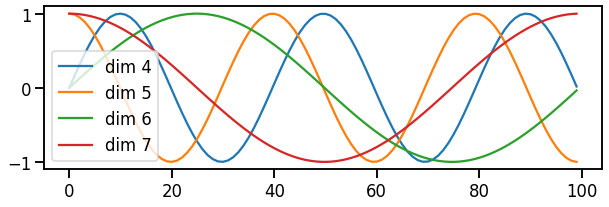

In [36]:
plt.figure(figsize=(10, 3))
pe = PositionalEncoding(20, 0)
y = pe.forward(Variable(torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

## 3.5 Self-Attention

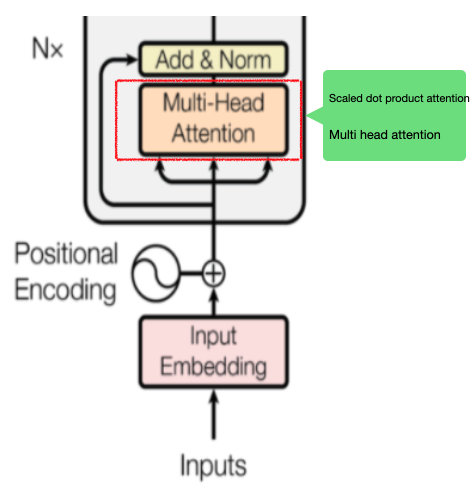

In [30]:
Image('qq1.png',width=500)

우리는 Multi-Head Attention을 구하기 위해, 아래 그림과 같이 3 가지 단계로 나눠서 알아본다.

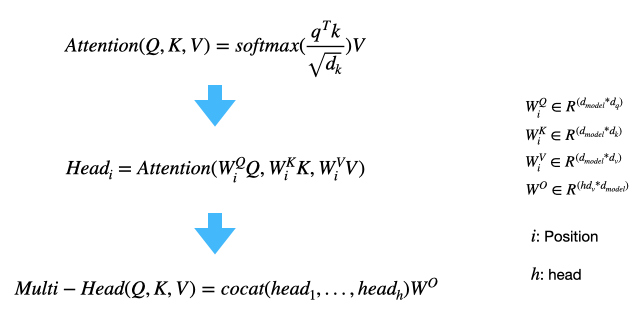

In [15]:
Image('qq6.png',width=800)

- **Attention:** 지난 시간에 알아보았던 (Vanila) 어텐션은 "**디코더 내**에서 output을 예측하는 매 timestep 마다, 동일한 timestep에서 **인코더 내의** 전체 inputs을 조사하는 와중에, 그것들 중 해당 timestep에서 예측할 디코더 내의 output과 더 관련이 있을수록, 더 높은 가중치를 해당 input에 두어 그것에 주목attention하는" 과정이라고 요약될 수 있다.   
- **Self-Attention:** 셀프 어텐션은 어텐션 과정을 inputs 자신에 대해 수행한다는 의미에서 이 같이 불린다. 우리는 이것을 알아보기 위하여, 먼저 Scaled dot-product attention에 대해 알아보고, 여러 개의 이 수행을 병렬적으로 처리하는 Multihead Attention에 대해 알아볼 것이다.

#### 셀프 어텐션이 무엇을 수행하는가에 대한 직관적 설명  
 
 (1) **철수**는 국어보다 수학 과목을 좋아하지만 **그**가 가장 좋아하는 과목은 사실 음악이다  
   
> 위 문장 (1)은 역접('-만')에 의해 두 문장이 결합된 하나의 문장이고, 여기서 '철수'와 '그'는 동일한 대상을 지칭한다. 즉, 이 문장에서 '그'는 '철수'에 대한 가주어이다. 컴퓨터는 어떻게 이 가주어와 진주어가 동일한 대상을 지칭한다는 것을 알 수 있는가? 이것에 대한 답을 알아보기 위해 우리는 self-attention을 공부할 것이다. self-attention은 Input 문장의 각 단어들 간의 관련성을 조사하여 높은 관련성을 지니는 것들 간의 관계에 높은 가중치를 부여한다.

### 3.5.1 Scaled dot-product Attention  
  


"어텐션은 일반적으로 [additive attention](https://arxiv.org/abs/1409.0473)과 dot-product attention으로 계산된다. 우리는 여기서 후자의 방식에 $\frac{1}{\sqrt{d_k}}$을 가지고 스케일링한 방식을 채택한다. 이 방법은 전자의 그것보다 실용적으로 더 빠르고 공간적으로 효율적이다. 왜냐하면 이것은 매우 최적화된optimized 행렬곱으로 수행될 수 있기 때문이다." [4]의 일부 번역.  
  
 셀프 어텐션에 대해 설명할 때, query,key,value를 동원해서 설명하는 것은 일반적이다. 여기서도 이것들을 가지고 어텐션 메커니즘에 대해 설명하고자 한다. 

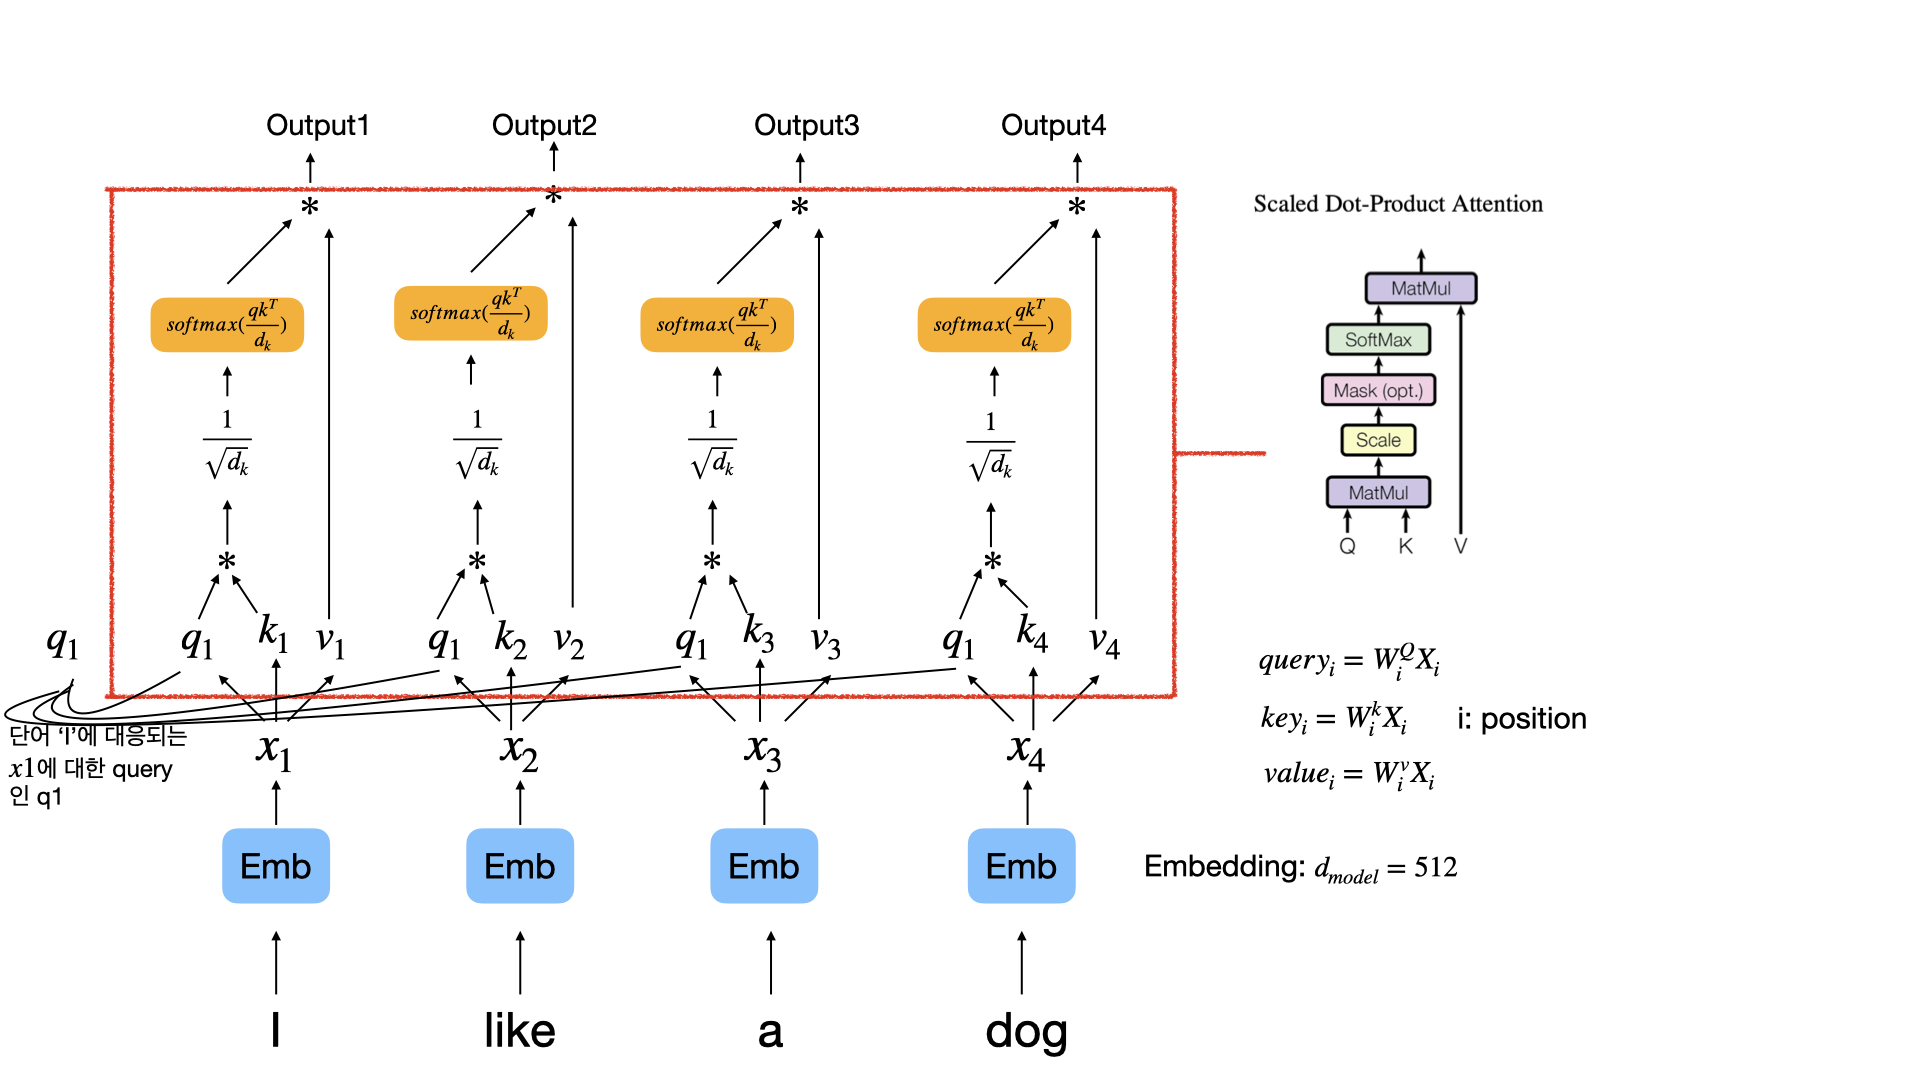

In [7]:
Image('qq4.jpeg',width=1000)

위 그림을 참고하여 셀프 어텐션에 대해 이해해보자. 셀프 어텐션은 자기 자신에 대해, 즉 입력 문장 자신에 대해 어텐션을 한다. 여기서는 단어 'I'에 대응되는 밀집 벡터 $x_1$에 대한 쿼리를 $q_1$라고 해보자. 그리고 위 그림은 이 $q_1$을 가지고 단어 'I'와 다른 단어들 간의 관련성을 구하는 상황을 도해한 것이라고 해보자. 여기서 임베딩 벡터는 512 이다. 따라서, 각 포지션(i)의 산출값은 512 개의 dimensionality를 갖는다.   

여기서 주목할 점은 $q_1$을 가지고 다른 단어 간의 관계를 조사할 시, 이 쿼리값과 대응되는 'I'가 있는 포지션의 softmax가 나머지 포지션에 있는 다른 단어들과 대응되는 softmax values 보다 더 크다는 것이다. 이 귀결은 자연스럽다. 왜냐하면 단어 'I'는 자기 자신에 대해 가장 유관성이 높을 것이기 때문이다. 상황은 $q_i$의 i가 변해도 마찬가지로 해당 포지션(i)의 입력 단어에 상응하는 softmax 값이 가장 높을 것이다.

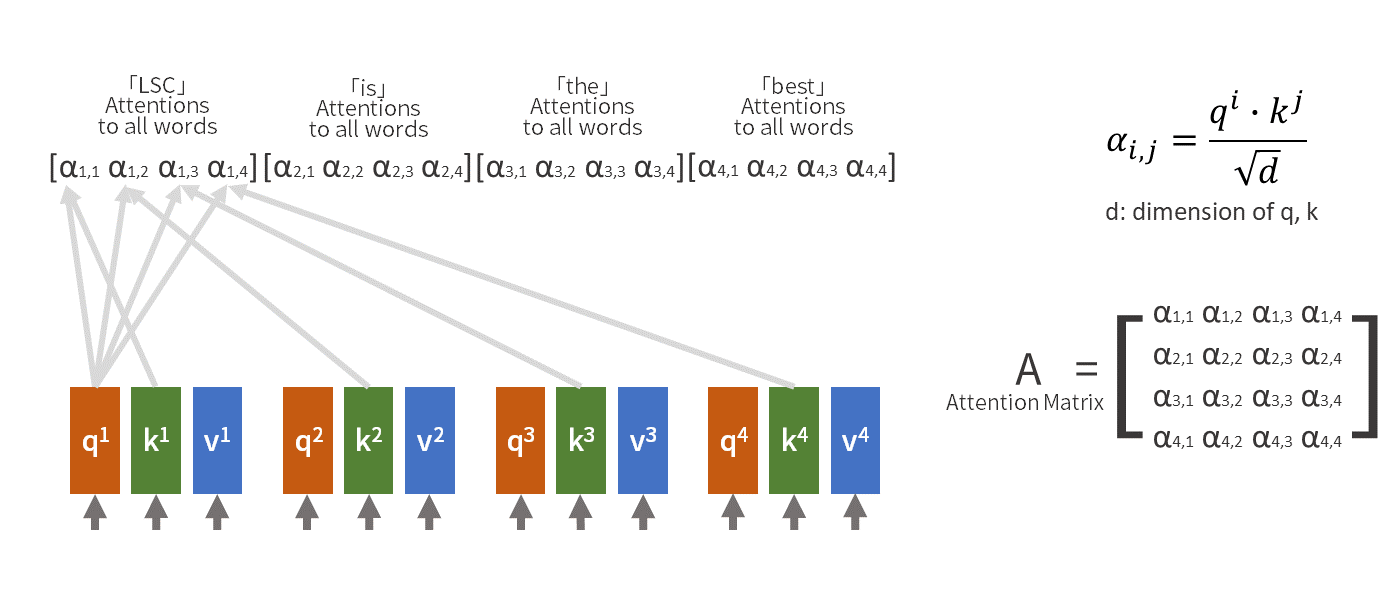

그림 출처: References [3]

앞의 설명은 위 움직이는 이미지의 한 수행 부분을 보여주었을 뿐이었다. 위의 이미지는 하나의 head 내의 self-Attention의 과정을 보여준다. 여기서 주목할 점은 Attention Matrix의 **한 행row은 하나의 포지션에 대한 산출된 벡터**라는 것이다. 사실 지금까지의 벡터 표현을 이용한 설명은 이론을 전달하기 위해 동원된 것이었다.  

실제 사용에서, 위 셀프-어텐션 과정은 사실 **행렬 단위로 수행**된다. 더욱이, 이러한 방식으로 계산하는 것은 학습을 더 빠르게 완료될 수 있게 해준다. 아래 그림은 'I am a student' 문장이 행렬 연산으로 어텐션되는 과정을 보여준다.

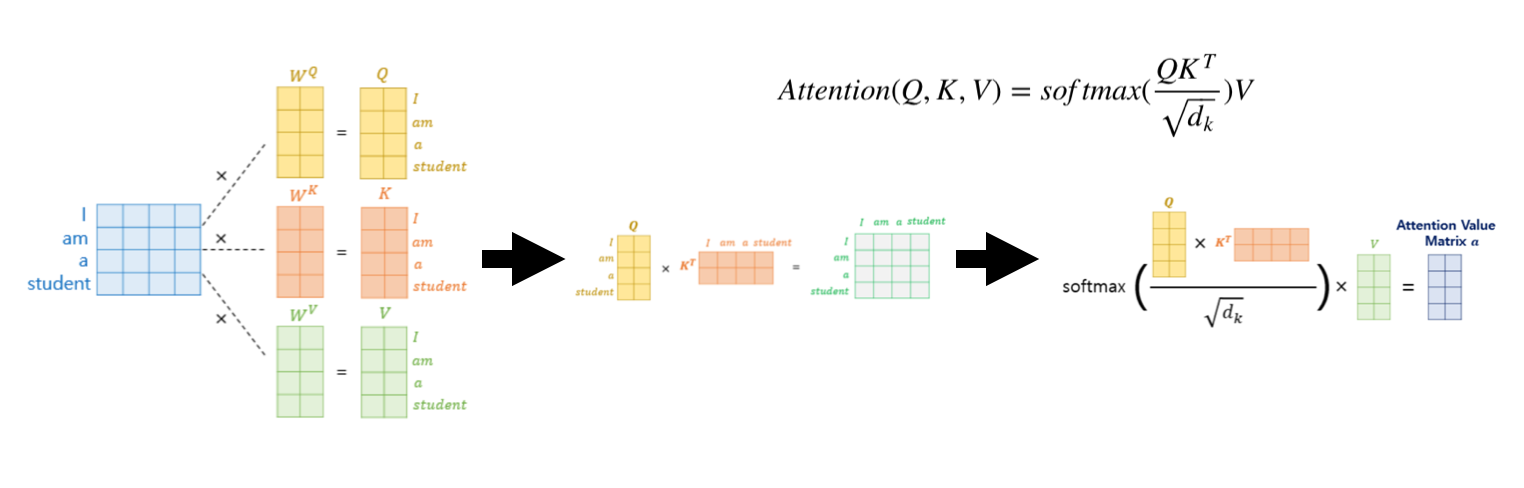

In [52]:
Image('qq8.png',width=1900)

그림 출처 [9]

In [44]:
def attention(query, key, value, mask=None): # 디코더에서는 mask를 사용하고, 인코더에서는 사용하지 않는다.
    d_k = query.shape[-1]
    scores = torch.dot(query, key.transpose(-2,-1))/math.sqrt(d_k) # key에 대한 일반적인 Transpose일 뿐
                                                                    # explosion을 방지하기 위해 d_k로 scaling
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    # attention weight : (batch_size, num_heads, query의 문장 길이, key의 문장 길이)
    attention_weights = F.softmax(scores, dim=-1)
    # output : (batch_size, num_heads, query의 문장 길이, d_model/num_heads)
    output = torch.dot(attention_weight, value)


    return output, attention_weights


### 3.5.2 Multi-Head Attention  
  


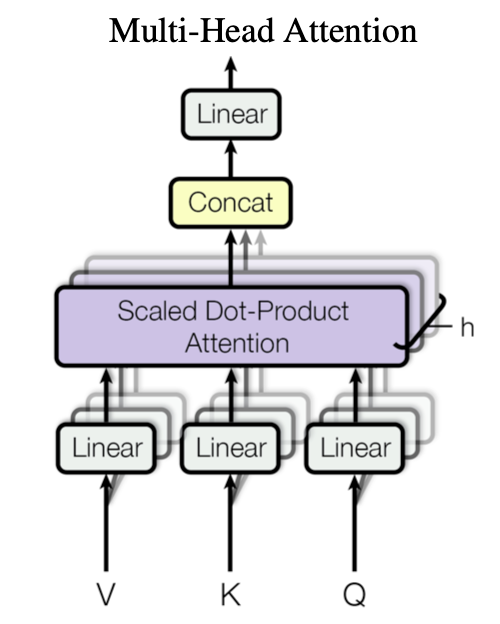

In [13]:
Image('qq5.png',width=400,height=500)

우리는 앞에서 $d_{model}=512$라고 설정했다. 논문에 따르면, 우리는 8 개의 heads로 위 과정을 나누어$\frac{d_{model}}{num\_heads}=$ 64 개의 dimensionality를 가진 행렬들을 병렬  처리parallelization할 수 있다. 즉, 64 차원을 가지는 $Q_i$,$K_i$,$V_i$ ('i' means position)에 대한 8 개의 어텐션이 병렬적으로 수행된다.   



#### Advantages  
- 이것은 Motivation에서 언급했던 RNN을 사용할 때 가지는 곤경을 극복하는 방법이다. 우리는 이 병렬화를 통해 모델의 더 빠른 연산 수행을 가능하게 한다.  
  
- 멀티-헤드 어텐션은 모델로 하여금 다양한 position에서 여러 representation subspace로부터 정보들에 주목attention하게끔 해준다. 단일 어텐션 헤드에서는 어텐션 계산 시 평균화되기 때문에 이것을 방해한다. 필자는 멀티-헤드 어텐션의 위 같은 특성은 기계 번역 시 성능을 높여주는 하나의 요인이 되는 것이 아닌가 짐작한다.

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__ (self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        # Assume that d_v = d_k
        self.d_k = d_model//h
        self.h= h # The number of heads
        self.linears = clones(nn.Linear(d_model,d_model),4)
        self.attn=None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        if mask is not None:

            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k 

        query, key, value = [l(x).view(nbatches,-1,self.h,self.d_k).transpose(1,2)
        for l,x in zip(self.linears, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch. 
        x, self.attn = attention(query, key, value, mask=mask, 
                                 dropout=self.dropout)
        
        x = x.transpose(1,2).contiguous().view(nbatches,-1,self.h*self.d_k)
        
        return self.linears[-1](x)


## 3.6 Point-Wise FeedForward

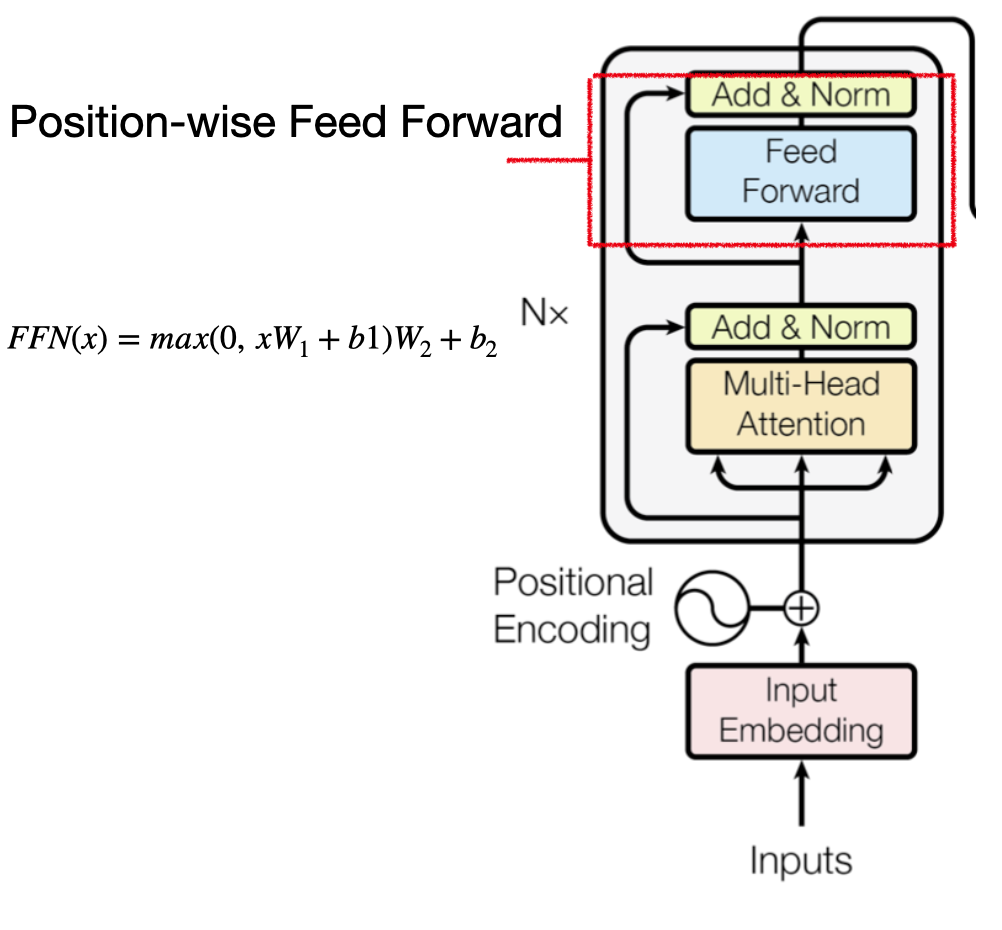

In [9]:
Image('q9.png',width=500,height=400)

인코더와 디코더 내의 각 레이어들은 FullyConnected Feed-Forward Net을 포함한다. 이것은 두 개의 선형 변환과 그 사이에 있는 ReLU로 구성된다. 이것은 각 inputs(position)마다 독립적으로 적용되어 그것에 상응하는 각 output을 출력한다.

In [ ]:
def PositionwiseFeedForward(nn.Module):

    def __init__(self, d_model, hidden):

        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model,hidden)
        self.linear2 = nn.Linear(hidden, d_model)
        self.relu = nn.ReLU()
        
    def forward(self, x):

        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

# References  
  
[1] Vaswani, Ashish, et al. "Attention is all you need." Advances in neural information processing systems. 2017.
  
[2] Ba, Jimmy Lei, Jamie Ryan Kiros, and Geoffrey E. Hinton. "Layer normalization." arXiv preprint arXiv:1607.06450 (2016).  

[3] https://medium.com/lsc-psd/introduction-of-self-attention-layer-in-transformer-fc7bff63f3bc  
  
[4] http://nlp.seas.harvard.edu/2018/04/03/attention.html#encoder  
[5] http://jalammar.github.io/illustrated-transformer/  
[6] https://mlexplained.com/2018/11/30/an-overview-of-normalization-methods-in-deep-learning/ Normalizations 비교  
[7] https://itrepo.tistory.com/36 /Residual Connection 요약  
[8] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.  
[9] https://wikidocs.net/31379